In [5]:

from inspect import trace
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr

import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as wb
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from tqdm.auto import tqdm
import os


In [2]:
prices = pdr.get_data_yahoo(('SQQQ', 'TQQQ'))

[*********************100%***********************]  2 of 2 completed


In [3]:
# generate a random stationary series and do adf test

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts



# generate a random non-stationary series and do adf test
x = np.random.randn(1000)
results = []
for i in tqdm(range(30, len(x))):
    result = ts.adfuller(x[:i])
    if result[0] > result[4]['5%']:
        results.append(False)
    else:
        results.append(True)
        
sum(results)/len(results)


100%|██████████| 970/970 [00:13<00:00, 70.40it/s] 


0.9938144329896907

In [4]:
prices = prices[['Adj Close']].dropna()
prices

Adj Close           
                     SQQQ       TQQQ
Date                                
2010-02-11  462430.218750   0.425410
2010-02-12  458585.656250   0.427152
2010-02-16  442306.312500   0.443697
2010-02-17  435518.218750   0.451227
2010-02-18  425065.781250   0.459781
...                   ...        ...
2023-07-18      16.660000  46.320000
2023-07-19      16.660000  46.320000
2023-07-20      17.850000  43.070000
2023-07-21      18.030001  42.689999
2023-07-24      17.940001  42.860001

[3384 rows x 2 columns]

In [ ]:
import sys
sys.path.append("../")


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
def statsGen(data):
    
    adjClose = data.iloc[:, :2]
    result = coint_johansen(adjClose, det_order=0, k_ar_diff=1)
    
    return result.lr1, result.cvt, result.lr2, result.cvm, result.evec
    

ADF Statistic: -4.852133
p-value: 0.000043


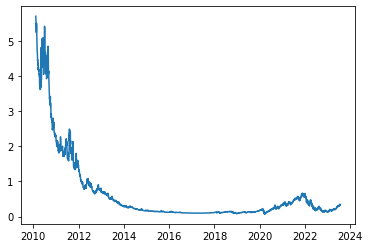

In [ ]:
results = coint_johansen(prices, det_order=0, k_ar_diff=1)
results.lr1, results.cvt, results.lr2, results.cvm, results.evec

top_eigenvec = results.evec[:, 0]
# build the portfolio
portfolio = pd.DataFrame()
portfolio['stock_1'] = prices.iloc[:, 0]
portfolio['stock_2'] = prices.iloc[:, 1]
portfolio['prices'] = top_eigenvec[0] * portfolio['stock_1'] + top_eigenvec[1] * portfolio['stock_2']


# test if this series is stationary
from statsmodels.tsa.stattools import adfuller
result = adfuller(portfolio['prices'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

plt.plot(portfolio['prices'])


In [ ]:
# eigenvalues
def pass_test(results):
    if results.lr1[0] > results.cvt[0, 0]:
        return True
    return False
    
passed = []    
for i in range(50, len(prices)):
    history = prices.iloc[:i, :]
    results = coint_johansen(history, det_order=0, k_ar_diff=1)
    passed.append(pass_test(results))
    

        


In [ ]:
checked_num = len(passed)
print('checked_num: ', checked_num)
print('passed_num: ', sum(passed))
print('passed_pct: ', sum(passed) / checked_num)

checked_num:  3333
passed_num:  2765
passed_pct:  0.8295829582958296


In [ ]:
results.evec

array([[1.23095188e-05, 3.07330599e-06],
       [7.69115225e-03, 5.88462808e-02]])

In [ ]:
a = 0
not a

True

In [ ]:

# importing pandas as pd
import pandas as pd
  
# importing numpy as np
import numpy as np
  
# dictionary of lists
dict = {'First Score':[True, False, np.nan, False],
        'Second Score': [30, 45, 56, np.nan],
        'Third Score':[np.nan, 40, 80, 98]}
  
# creating a dataframe from list
df = pd.DataFrame(dict)
  
df.mean(axis = 0)


First Score      0.333333
Second Score    43.666667
Third Score     72.666667
dtype: float64

In [ ]:
# cwd = os.getcwd()
# # get rid of the last folder
# cwd = os.path.dirname(cwd)

# stationary = []
# sss = pd.DataFrame(columns=['symb1', 'symb2'])
# path = os.path.join(cwd, 'Cointegrated_Pairs', 'pairs.csv')
# data = pd.read_csv(path)
# for i in range(len(data)):
#     tickers = (data['symb1'][i], data['symb2'][i])

#     prices = wb.DataReader(tickers, data_source='yahoo', interval='1d')['Adj Close']
#     prices = prices.dropna()
#     info = statsGen(prices)
#     lr_stats = info[0][0]
#     lr_90pct_threshold = info[1][0][0]
#     mle_stats = info[2][0]
#     mle_90pct_threshold = info[3][0][0]
    
#     if lr_stats > lr_90pct_threshold and mle_stats > mle_90pct_threshold:
#         stationary.append(tickers)
#         sss = sss.append({'symb1': tickers[0], 'symb2': tickers[1]}, ignore_index=True)
        
# print(len(stationary)/len(data))

In [8]:
tickers = ('KO', 'PEP')

# scrap once a month
data = wb.DataReader(tickers, data_source='yahoo', interval='1d')[['Adj Close', 'Volume']]
# make it a monthly data
data = data.resample('M').last()


data = data.dropna()
data

[*********************100%***********************]  2 of 2 completed


Adj Close                Volume            
                   KO         PEP        KO         PEP
Date                                                   
1972-06-30   0.320038    0.400247   1056000    135000.0
1972-07-31   0.340415    0.416949    326400    167400.0
1972-08-31   0.338617    0.411580    547200    270000.0
1972-09-30   0.339012    0.399018   1440000    189000.0
1972-10-31   0.345624    0.399616    825600    939600.0
...               ...         ...       ...         ...
2023-03-31  61.561153  181.035355  14440900   4479800.0
2023-04-30  63.665134  189.565750  13686700   4607500.0
2023-05-31  59.209068  181.085007  59432200  20414600.0
2023-06-30  60.220001  185.220001  19737000   7635100.0
2023-07-31  62.334999  190.919998   3506448   4225800.0

[614 rows x 4 columns]

In [9]:
data[f'coef_{tickers[0]}'] = None
data[f'coef_{tickers[1]}'] = None
data['portfolio'] = None
data


Adj Close                Volume             coef_KO coef_PEP  \
                   KO         PEP        KO         PEP                    
Date                                                                       
1972-06-30   0.320038    0.400247   1056000    135000.0    None     None   
1972-07-31   0.340415    0.416949    326400    167400.0    None     None   
1972-08-31   0.338617    0.411580    547200    270000.0    None     None   
1972-09-30   0.339012    0.399018   1440000    189000.0    None     None   
1972-10-31   0.345624    0.399616    825600    939600.0    None     None   
...               ...         ...       ...         ...     ...      ...   
2023-03-31  61.561153  181.035355  14440900   4479800.0    None     None   
2023-04-30  63.665134  189.565750  13686700   4607500.0    None     None   
2023-05-31  59.209068  181.085007  59432200  20414600.0    None     None   
2023-06-30  60.220001  185.220001  19737000   7635100.0    None     None   
2023-07-31  62.334999  190.919998   3506448   4225800.0    None     None   

           portfolio  
                      
Date                  
1972-06-30      None  
1972-07-31      None  
1972-08-31      None  
1972-09-30      None  
1972-10-31      None  
...              ...  
2023-03-31      None  
2023-04-30      None  
2023-05-31      None  
2023-06-30      None  
2023-07-31      None  

[614 rows x 7 columns]

In [40]:
# for every entry, use all previous closing prices as input to the cointegration test
# return the results for every week entry
# before market close, eigenvalue and eigenvector are calculated and will be kept for the next week
# since eigenvector changes, high loww should be fouund using combination of high and low of the week


for i in tqdm(range(20, len(data))):

    evec = statsGen(data.iloc[:i,:])[4][:, 0]
    coef1 = evec[0]
    coef2 = evec[1]
    data.iloc[i, -3] = coef1
    data.iloc[i, -2] = coef2

    data.iloc[i, -1] = coef1 * data.iloc[i, 0] + coef2 * data.iloc[i, 1]

    
        
    
    
    

# print("Eigenvalue: \n", eigenvalue)
# print("Eigenvector: \n", eigenvector)
# print("\n")
# print("Maximum eigenvalue statistic: \n", max_eigen_statistic)
# print("Critical values (90%, 95%, 99%) of maximum eigenvalue statistic. \n", cvm)
# print("\n")
# print("Trace statistic: \n", trace_statistic)
# print("Critical values (90%, 95%, 99%) of trace statistic. \n", cvt)

100%|██████████| 594/594 [00:01<00:00, 455.10it/s]


In [41]:
# get rid of all datas before the last None value
adjdata = data.dropna()
adjdata




Adj Close                Volume                 coef_KO  \
                   KO         PEP        KO         PEP               
Date                                                                  
1974-02-28   0.280844    0.311751    854400    475200.0  109.310223   
1974-03-31   0.270151    0.293042   1209600    540000.0  116.442136   
1974-04-30   0.258805    0.290595   1382400    318600.0  129.649639   
1974-05-31   0.262791    0.273465   1584000    410400.0  124.373397   
1974-06-30   0.266116    0.300775   1632000    696600.0  145.088779   
...               ...         ...       ...         ...         ...   
2023-03-31  61.561153  181.035355  14440900   4479800.0    0.106711   
2023-04-30  63.665134  189.565750  13686700   4607500.0    0.059667   
2023-05-31  59.209068  181.085007  59432200  20414600.0    0.019488   
2023-06-30  60.220001  185.220001  19737000   7635100.0    0.073833   
2023-07-31  62.334999  190.919998   3506448   4225800.0    0.068193   

              coef_PEP portfolio  
                                  
Date                              
1974-02-28  -94.322883  1.293861  
1974-03-31  -97.259115  2.955888  
1974-04-30  -101.09038  4.177582  
1974-05-31   -99.92495  5.358211  
1974-06-30 -107.668708  6.226355  
...                ...       ...  
2023-03-31   -0.016074  3.659396  
2023-04-30    0.002097  4.196237  
2023-05-31    0.017161  4.261369  
2023-06-30   -0.003542  3.790174  
2023-07-31   -0.001603  3.944781  

[594 rows x 7 columns]

In [45]:
result = statsGen(adjdata)
result

(array([24.43438962,  4.89417797]),
 array([[13.4294, 15.4943, 19.9349],
        [ 2.7055,  3.8415,  6.6349]]),
 array([19.54021165,  4.89417797]),
 array([[12.2971, 14.2639, 18.52  ],
        [ 2.7055,  3.8415,  6.6349]]),
 array([[ 0.04524013, -0.31695024],
        [ 0.00686003,  0.11854609]]))

In [42]:
copy = adjdata['Adj Close']['KO']
copy.loc['2020':] = 30
copy

C:\Users\Michael\AppData\Local\Temp\ipykernel_20056\2126137173.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy.loc['2020':] = 30


Date
1974-02-28     0.280844
1974-03-31     0.270151
1974-04-30     0.258805
1974-05-31     0.262791
1974-06-30     0.266116
                ...    
2023-03-31    30.000000
2023-04-30    30.000000
2023-05-31    30.000000
2023-06-30    30.000000
2023-07-31    30.000000
Freq: M, Name: KO, Length: 594, dtype: float64

In [43]:
new_df = pd.concat([copy, adjdata['Adj Close']['PEP']], axis=1)


,KO,PEP
Date,,
1974-02-28,0.280844,0.311751
1974-03-31,0.270151,0.293042
1974-04-30,0.258805,0.290595
1974-05-31,0.262791,0.273465
1974-06-30,0.266116,0.300775
...,...,...
2023-03-31,30.000000,181.035355
2023-04-30,30.000000,189.565750
2023-05-31,30.000000,181.085007


In [44]:
result = statsGen(new_df)
result

(array([22.08480074,  0.15318459]),
 array([[13.4294, 15.4943, 19.9349],
        [ 2.7055,  3.8415,  6.6349]]),
 array([21.93161615,  0.15318459]),
 array([[12.2971, 14.2639, 18.52  ],
        [ 2.7055,  3.8415,  6.6349]]),
 array([[ 0.00105059, -0.16058766],
        [-0.02383256,  0.04128028]]))

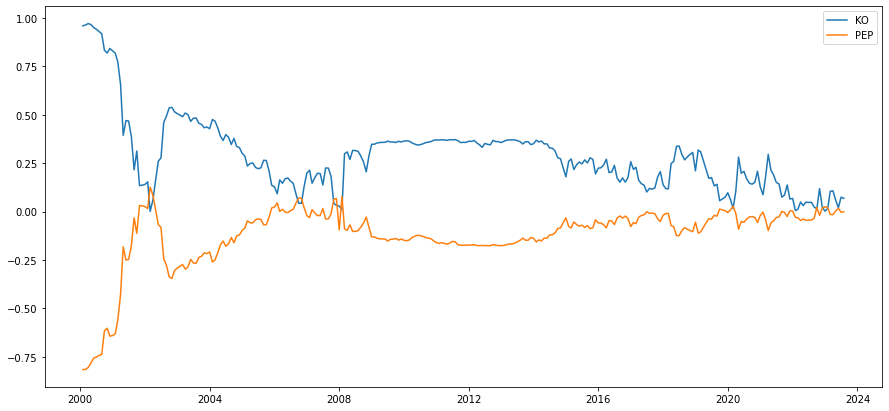

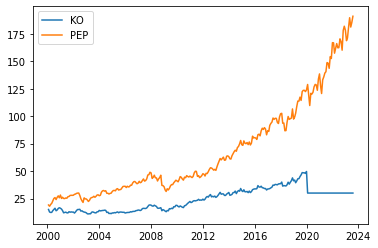

In [48]:

#plot period after 1990
plt.figure(figsize=(15,7))
temp = adjdata.loc['2000-01-01':]
plt.plot(temp[f'coef_{tickers[0]}'], label=tickers[0])
plt.plot(temp[f'coef_{tickers[1]}'], label=tickers[1])
plt.legend()
plt.show()

temp = new_df.loc['2000-01-01':]
# plot the two adjusted prices
plt.plot(temp['KO'], label=tickers[0])
plt.plot(temp['PEP'], label=tickers[1])
plt.legend()
plt.show()



In [103]:
# vecm
# Delta y_t = A_1 Delta y_{t-1} + ... + A_p Delta y_{t-p} + B (y_{t-1} - Π y_{t-1}) + e_t


# where:

# y_t is a vector of the original time series at time t
# Delta y_t is the first difference of y_t, which can be used to remove any trend or drift in the series
# A_1, ..., A_p are the short-term dynamics of the model, which capture the dependence of the series on their past values
# B is a matrix of coefficients that represent the long-term relationships among the series, which capture the cointegrating relationships
# Π is a matrix of lagged coefficients that represent the adjustment towards equilibrium
# e_t is a vector of errors or residuals at time t
# In this equation, the matrix B represents the coefficients of the original time series in the linear combinations that form the cointegrating relationships. The columns of B correspond to the eigenvectors obtained from the coint_johansen test.

# For example, suppose you have two time series, X and Y, and you want to determine whether they are cointegrated. You can run the coint_johansen test on the data and obtain the eigenvectors [a, b] and [c, d], which represent the two linear combinations aX + bY and cX + dY.

# You can then use these eigenvectors to construct the VECM for the two series, which would take the form:
    
# Delta [X_t, Y_t] = A_1 Delta [X_{t-1}, Y_{t-1}] + ... + 
# A_p Delta [X_{t-p}, Y_{t-p}] + B ([X_{t-1}, Y_{t-1}] - Π [X_{t-1}, Y_{t-1}]) + e_t
# where:

# X_t and Y_t are the original time series at time t
# B is a matrix with columns [a, b] and [c, d], representing the linear combinations aX + bY and cX + dY

# cointegration不代表要一起动, unless correlation is high, otherwise, moving one can change the portfolio too. 
# 只是给你stationary portfolio, nothing to do with hedging
# based on the coefficients, you can tell which one will generate more effect and trade on that
# trends need to be matched


In [104]:
adjdata['rolling_mean'] = adjdata['portfolio'].expanding().mean()


C:\Users\Michael\AppData\Local\Temp\ipykernel_26312\700937297.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adjdata['rolling_mean'] = adjdata['portfolio'].expanding().mean()


ADF Statistic: -5.069212
p-value: 0.000016


C:\Users\Michael\AppData\Local\Temp\ipykernel_26312\2792591784.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adjdata['rolling_std'] = adjdata['portfolio'].expanding().std()


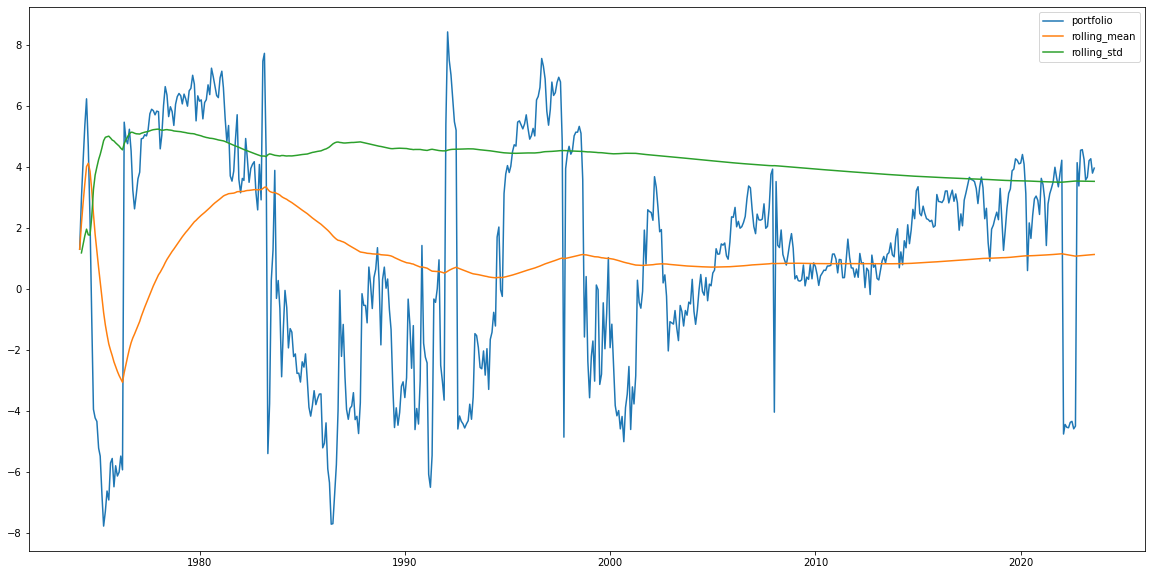

In [105]:
# plot the portfolio
plt.figure(figsize=(20, 10))
plt.plot(adjdata['portfolio'], label='portfolio')
plt.plot(adjdata['rolling_mean'], label='rolling_mean')

# test if this series is stationary
from statsmodels.tsa.stattools import adfuller
result = adfuller(adjdata['portfolio'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

adjdata['rolling_std'] = adjdata['portfolio'].expanding().std()
plt.plot(adjdata['rolling_std'], label='rolling_std')
plt.legend()
    

In [198]:
adjdata

Adj Close              coef_AMC coef_MSFT portfolio rolling_mean  \
                 AMC        MSFT                                              
Date                                                                          
2020-02-18  6.997073  181.170883  0.002141  0.028826  5.237333     5.237333   
2020-02-19  7.265427  181.714218  0.005186 -0.027976 -5.045972     0.095681   
2020-02-20  7.712683  178.939240  0.019094 -0.026366 -4.570607    -1.459749   
2020-02-21  7.414512  173.282501  0.019369  0.030319  5.397403     0.254539   
2020-02-24  7.007012  165.811371  0.252327  0.037814  8.038133     1.811258   
...              ...         ...       ...       ...       ...          ...   
2023-05-19  5.030000  318.339996  0.106369  0.003214  1.558096     4.297185   
2023-05-22  5.120000  321.179993  0.106383  0.003215  1.577234     4.293876   
2023-05-23  5.030000  315.260010  0.106395  0.003216  1.549194     4.290541   
2023-05-24  4.880000  313.850006  0.106385  0.003228   1.53218     4.287193   
2023-05-25  4.700000  325.920013  0.106246  0.003292  1.572329     4.283902   

           rolling_std  
                        
Date                    
2020-02-18         NaN  
2020-02-19    7.271395  
2020-02-20    5.804711  
2020-02-21    5.849637  
2020-02-24    6.146589  
...                ...  
2023-05-19    3.221254  
2023-05-22    3.220689  
2023-05-23    3.220151  
2023-05-24    3.219629  
2023-05-25    3.219062  

[825 rows x 7 columns]

In [199]:
# strat 1: simply trade when reach bottom or top 10%

adjdata['entry'] = 0

def entrypoint(data):
    
    # long run expectation, wait for four trading years
    for i in range(1, len(data)):
        historical = data.iloc[:i, :]
        today_value = data.iloc[i, -4]

        above = historical[historical['portfolio'] >= today_value].shape[0] / historical.shape[0]
        below = historical[historical['portfolio'] <= today_value].shape[0] / historical.shape[0]
        if above < 0.025:
            data.iloc[i, -1] = -1
        elif below < 0.025:
            data.iloc[i, -1] = 1
        else:
            data.iloc[i, -1] = 0
            
    return data

adjdata = entrypoint(adjdata)
adjdata

Adj Close              coef_AMC coef_MSFT portfolio rolling_mean  \
                 AMC        MSFT                                              
Date                                                                          
2020-02-18  6.997073  181.170883  0.002141  0.028826  5.237333     5.237333   
2020-02-19  7.265427  181.714218  0.005186 -0.027976 -5.045972     0.095681   
2020-02-20  7.712683  178.939240  0.019094 -0.026366 -4.570607    -1.459749   
2020-02-21  7.414512  173.282501  0.019369  0.030319  5.397403     0.254539   
2020-02-24  7.007012  165.811371  0.252327  0.037814  8.038133     1.811258   
...              ...         ...       ...       ...       ...          ...   
2023-05-19  5.030000  318.339996  0.106369  0.003214  1.558096     4.297185   
2023-05-22  5.120000  321.179993  0.106383  0.003215  1.577234     4.293876   
2023-05-23  5.030000  315.260010  0.106395  0.003216  1.549194     4.290541   
2023-05-24  4.880000  313.850006  0.106385  0.003228   1.53218     4.287193   
2023-05-25  4.700000  325.920013  0.106246  0.003292  1.572329     4.283902   

           rolling_std entry  
                              
Date                          
2020-02-18         NaN     0  
2020-02-19    7.271395     1  
2020-02-20    5.804711     0  
2020-02-21    5.849637    -1  
2020-02-24    6.146589    -1  
...                ...   ...  
2023-05-19    3.221254     0  
2023-05-22    3.220689     0  
2023-05-23    3.220151     0  
2023-05-24    3.219629     0  
2023-05-25    3.219062     0  

[825 rows x 8 columns]

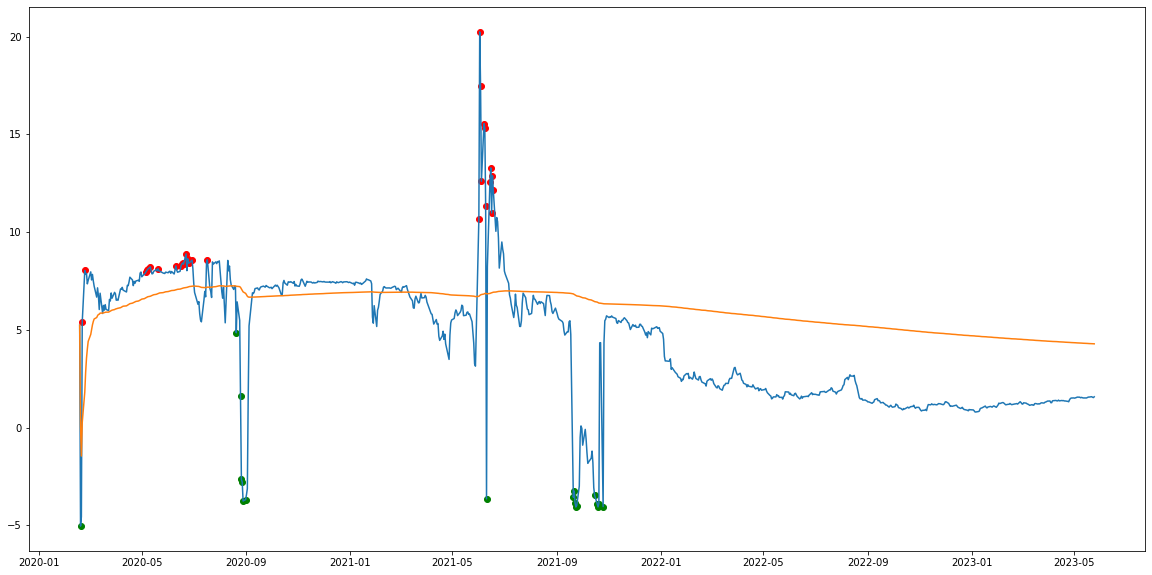

In [200]:
longing = adjdata[adjdata['entry'] == 1].index
shorting = adjdata[adjdata['entry'] == -1].index

# mark this point on the line chart with different color
plt.figure(figsize=(20, 10))
plt.plot(adjdata['portfolio'])
plt.plot(adjdata['rolling_mean'])
plt.scatter(longing, adjdata.loc[longing, 'portfolio'], color='g')
plt.scatter(shorting, adjdata.loc[shorting, 'portfolio'], color='r')


In [202]:
adjdata[adjdata['entry'] == -1]

Adj Close              coef_AMC coef_MSFT  portfolio rolling_mean  \
                  AMC        MSFT                                               
Date                                                                            
2020-02-21   7.414512  173.282501  0.019369  0.030319   5.397403     0.254539   
2020-02-24   7.007012  165.811371  0.252327  0.037814   8.038133     1.811258   
2020-05-06   3.920000  177.115112  0.234293  0.039877   7.981231     6.644594   
2020-05-07   3.990000  178.143616  0.233696  0.039901    8.04059     6.669085   
2020-05-08   4.100000  179.191498  0.234029   0.03988   8.105673     6.693854   
2020-05-11   5.320000  181.190323  0.257396  0.037836   8.224806     6.719802   
2020-05-20   4.660000  180.644119  0.251967  0.038538   8.135814     6.855593   
2020-06-10   6.290000  191.522079  0.272409  0.034258   8.274688     7.051222   
2020-06-16   5.560000  188.340439  0.267281  0.036012   8.268688     7.099673   
2020-06-17   5.420000  188.992294  0.264115  0.036686   8.364786     7.114556   
2020-06-18   5.630000  191.016113  0.266256  0.036234   8.420391     7.129740   
2020-06-19   5.520000  189.877716  0.265846  0.036307    8.36136     7.143897   
2020-06-22   5.330000  195.151306  0.223704  0.039433   8.887652     7.163712   
2020-06-24   4.790000  192.495026   0.22099   0.03937   8.636991     7.189676   
2020-06-26   4.180000  191.025833  0.222715  0.039274   8.433322     7.216521   
2020-06-29   4.420000  193.078842  0.227118  0.039183   8.569192     7.231066   
2020-07-17   4.270000  197.398895  0.228539  0.038553   8.586177     7.184879   
2021-06-01  32.040001  243.046844  0.140176  0.025386  10.661184     6.714628   
2021-06-02  62.549999  242.948639  0.223503   0.02581  20.250715     6.756150   
2021-06-03  51.340000  241.386612  0.219647  0.025812   17.50743     6.789028   
2021-06-04  47.910000  246.377213  0.137392  0.024429  12.601288     6.806749   
2021-06-07  55.000000  249.344055  0.172191  0.024396  15.553529     6.833335   
2021-06-08  55.049999  248.125900  0.170754   0.02387  15.322711     6.859060   
2021-06-09  49.340000  249.127930  0.114871  0.022745  11.334149     6.872580   
2021-06-14  57.000000  255.317093   0.12175  0.021976  12.550661     6.862153   
2021-06-15  59.040001  253.813980  0.131731  0.021712  13.288248     6.881336   
2021-06-16  55.180000  252.851257  0.102285  0.021115  10.982985     6.893543   
2021-06-17  60.730000  256.309296  0.124215  0.020838  12.884599     6.911321   
2021-06-18  59.259998  254.865158   0.11635  0.020562  12.135535     6.926777   

           rolling_std entry  
                              
Date                          
2020-02-21    5.849637    -1  
2020-02-24    6.146589    -1  
2020-05-06    2.326888    -1  
2020-05-07    2.313419    -1  
2020-05-08    2.300782    -1  
2020-05-11    2.289554    -1  
2020-05-20    2.199146    -1  
2020-06-10    2.040513    -1  
2020-06-16    2.002815    -1  
2020-06-17    1.995582    -1  
2020-06-18    1.988799    -1  
2020-06-19    1.981607    -1  
2020-06-22    1.978935    -1  
2020-06-24    1.964755    -1  
2020-06-26    1.951464    -1  
2020-06-29    1.945891    -1  
2020-07-17    1.859116    -1  
2021-06-01    1.971625    -1  
2021-06-02    2.106510    -1  
2021-06-03    2.185694    -1  
2021-06-04    2.205821    -1  
2021-06-07    2.254629    -1  
2021-06-08    2.299194    -1  
2021-06-09    2.308848    -1  
2021-06-14    2.391166    -1  
2021-06-15    2.413260    -1  
2021-06-16    2.420023    -1  
2021-06-17    2.438358    -1  
2021-06-18    2.451263    -1

In [177]:
adjdata.loc['2020-02-19']

Adj Close     AMC       7.265427
              MSFT    181.714249
coef_AMC                0.005187
coef_MSFT              -0.027976
portfolio               5.237332
rolling_mean            5.237332
rolling_std                  NaN
entry                          0
Name: 2020-02-19 00:00:00, dtype: object

In [68]:
temp = adjdata.copy()

shift_term = abs(min(temp['portfolio']) - 20)
temp['portfolio'] += shift_term
temp['rolling_mean'] += shift_term

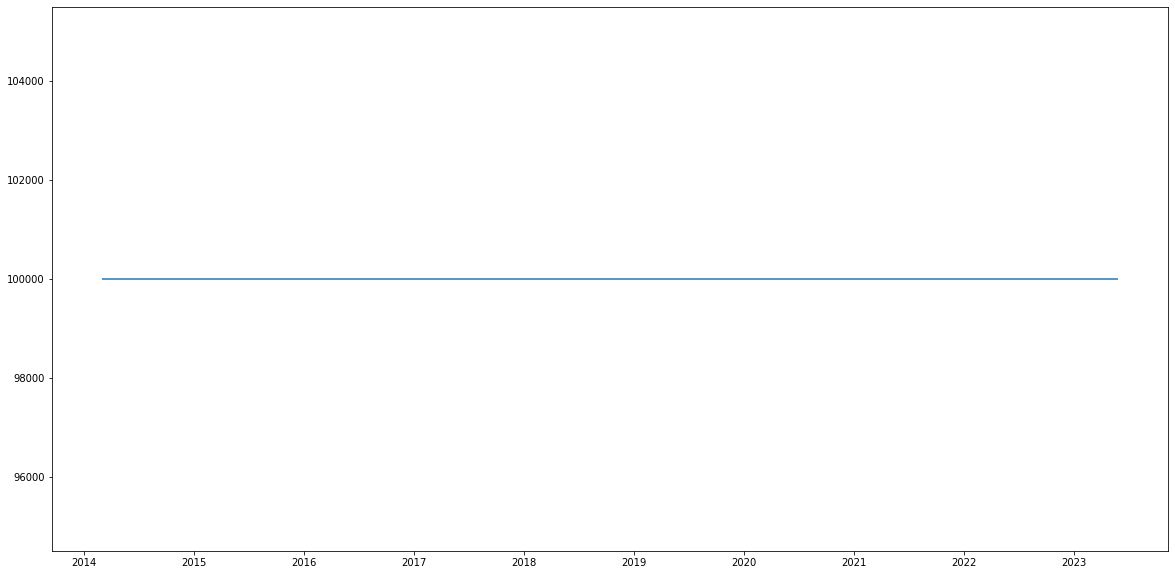

In [69]:
# no shorting backtest

profit = 0
available_capital = 100000
num_shares = 0
floating_portfolios_value = []
dates = temp.index

for i in range(len(temp)):
    
    ## exiting the next day
    available_capital += temp.iloc[i, -3] * num_shares
    num_shares = 0

 
    
    ## opening position
    # longing
    if temp.iloc[i, -1] == 1:
        
        if num_shares == 0:
            
            
            num_shares = available_capital // temp.iloc[i, -3]
            available_capital -= num_shares * temp.iloc[i, -3]
        
            
    # shorting
    elif temp.iloc[i, -1] == -1:
        
        if num_shares == 0:
           
            num_shares = - available_capital // temp.iloc[i, -3]
            available_capital -= num_shares * temp.iloc[i, -3]

        
            
      
    floating_portfolios_value.append(available_capital + num_shares * temp.iloc[i, -3])
    
# plot the floating value
plt.figure(figsize=(20, 10))
plt.plot(dates, floating_portfolios_value)



In [70]:
port_return = (floating_portfolios_value[-1] - 100000) / 100000
port_return

0.0

In [70]:
# geenrate two cointegrated series

a = np.random.randn(1000)
b = np.random.randn(1000) + 10

result = statsGen(pd.DataFrame({'a': a, 'b': b}))
coef = pd.DataFrame(columns=['a', 'b'])
for i in range(50, len(a)):
    result = statsGen(pd.DataFrame({'a': a[:i], 'b': b[:i]}))
    coef = coef.append({'a': result[4][0, 0], 'b': result[4][1, 0]}, ignore_index=True)
coef

C:\Users\Michael\AppData\Local\Temp\ipykernel_26312\263277887.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coef = coef.append({'a': result[4][0, 0], 'b': result[4][1, 0]}, ignore_index=True)
C:\Users\Michael\AppData\Local\Temp\ipykernel_26312\263277887.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coef = coef.append({'a': result[4][0, 0], 'b': result[4][1, 0]}, ignore_index=True)
C:\Users\Michael\AppData\Local\Temp\ipykernel_26312\263277887.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coef = coef.append({'a': result[4][0, 0], 'b': result[4][1, 0]}, ignore_index=True)
C:\Users\Michael\AppData\Local\Temp\ipykernel_26312\263277887.py:10: FutureWarning: The frame.append method is deprecated and will be re

,a,b
0,1.318897,-0.803079
1,1.336231,-0.806349
2,1.288490,-0.893308
3,1.150054,-1.065296
4,1.234872,-0.995106
...,...,...
945,1.214606,0.746163
946,1.201022,0.768403
947,1.253896,0.679845
948,1.231043,0.720590


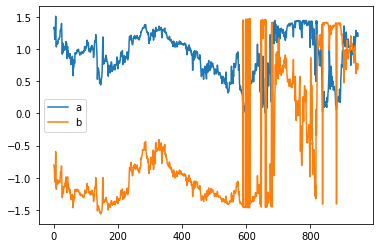

In [71]:
# plot the coefficients
plt.plot(coef['a'], label='a')
plt.plot(coef['b'], label='b')
plt.legend()
